# **Praktikum 1 - RNN untuk Analisis Sentimen**

### **Setup**

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar() # disables the progress bar that is typically displayed during the download or loading process of a dataset using TFDS

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric]) # plots the values of the specified metric from the training set
  plt.plot(history.history['val_'+metric], '') # plots the values of the same metric from the validation set
  plt.xlabel("Epochs") # sets the label for the x-axis of the plot to "Epochs", indicating the number of training epochs
  plt.ylabel(metric) # sets the label for the y-axis of the plot to the specified metric
  plt.legend([metric, 'val_'+metric]) # creates a legend for the plot, with the specified metric label and the validation metric label

### **Setup Input Pipeline**

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True) # loads the IMDB Reviews dataset using the TensorFlow Datasets (TFDS) library
train_dataset, test_dataset = dataset['train'], dataset['test'] # splits the datasets into training and testing subsets, stored in train_dataset and test_dataset

train_dataset.element_spec # provides information about the structure and types of elements in a dataset

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1): # extract one example from the training dataset, returns a new dataset containing only the first element of the original dataset
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"By 1976 the western was an exhausted genre and the makers of this film clearly knew it. Still, instead of shelving the project and saving us from having to watch it, they went ahead and made it anyway. Apparently in need of an interesting thread to get the audiences to come and see the film, they decided to make it as blatantly violent and unpleasant as possible. Hell, it worked for The Wild Bunch so why shouldn't it work here? Of course, The Wild Bunch had the benefit of a superb script but the script of The Last Hard Men is plain old-fashioned rubbish.<br /><br /> It's hard to figure out what attracted Charlton Heston and James Coburn to their respective roles. Heston plays a retired lawman who goes after an escaped bunch of convicts led by a violent outlaw (Coburn). The hunt becomes even more personal when Heston's daughter (Barbara Hershey) is kidnapped by the convicts and subjected to sexual degradation.<br /><br /> This is a bloodthirsty film indeed in which every time

**Explanation:**
1. train_dataset = train_dataset.shuffle(BUFFER_SIZE) - The shuffle() method shuffles the examples in the training dataset. The BUFFER_SIZE parameter specifies the number of examples to use for buffering and random sampling. Shuffling the dataset helps to introduce randomness and reduce potential bias during training.
2. train_dataset = train_dataset.batch(BATCH_SIZE) - The batch() method groups the examples into batches. The BATCH_SIZE parameter determines the number of examples in each batch. Batching the data allows for more efficient processing and training, as operations can be performed on multiple examples simultaneously.
3. train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE) - The prefetch() method adds a background task that prefetches batches of data while the model is training on the current batch. This helps to overlap the data preprocessing and model execution, reducing potential bottlenecks and improving overall performance. The tf.data.AUTOTUNE argument enables TensorFlow to automatically determine the optimal number of elements to prefetch based on available system resources.

### **Create Text Encoder**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

**Explanation:**
1. Retrieve Vocabulary: The get_vocabulary() method is called on the encoder object. This method returns the vocabulary, which is a list of words in the order they were added to the vocabulary.
2. Convert Vocabulary to NumPy Array: The np.array() function is used to convert the vocabulary list into a NumPy array. This makes it easier to manipulate and process the vocabulary.
3. Print First 20 Words: The vocab[:20] expression slices the NumPy array vocab and retrieves the first 20 elements. This effectively prints the first 20 words in the vocabulary.

In [ ]:
encoded_example = encoder(example)[:3].numpy() # slicing encoded representation then convert to numpy array
encoded_example # print encoded representation

array([[ 33,   1,   2, ...,   0,   0,   0],
       [ 10,  14,   1, ...,   0,   0,   0],
       [ 10, 434,  11, ...,   0,   0,   0]])

In [ ]:
for n in range(3): # demonstrates the round-trip encoding and decoding process using the TextVectorization layer
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"By 1976 the western was an exhausted genre and the makers of this film clearly knew it. Still, instead of shelving the project and saving us from having to watch it, they went ahead and made it anyway. Apparently in need of an interesting thread to get the audiences to come and see the film, they decided to make it as blatantly violent and unpleasant as possible. Hell, it worked for The Wild Bunch so why shouldn't it work here? Of course, The Wild Bunch had the benefit of a superb script but the script of The Last Hard Men is plain old-fashioned rubbish.<br /><br /> It's hard to figure out what attracted Charlton Heston and James Coburn to their respective roles. Heston plays a retired lawman who goes after an escaped bunch of convicts led by a violent outlaw (Coburn). The hunt becomes even more personal when Heston's daughter (Barbara Hershey) is kidnapped by the convicts and subjected to sexual degradation.<br /><br /> This is a bloodthirsty film indeed in which every ti

### **Create a Model**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[0.00766505]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 63ms/step
[0.00766505]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 101ms/step - loss: 0.6312 - accuracy: 0.5867 - val_loss: 0.4781 - val_accuracy: 0.7385
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4007 - accuracy: 0.8173 - val_loss: 0.3673 - val_accuracy: 0.8432
Epoch 3/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3466 - accuracy: 0.8484 - val_loss: 0.3401 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3224 - accuracy: 0.8635 - val_loss: 0.3461 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3134 - accuracy: 0.8652 - val_loss: 0.3300 - val_accuracy: 0.8490
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3094 - accuracy: 0.8686 - val_loss: 0.3255 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3044 - accuracy: 0.8703 - val_loss: 0.3347 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3145 - accuracy: 0.8584
Test Loss: 0.3145037889480591
Test Accuracy: 0.8583599925041199


(0.0, 0.6479001089930534)

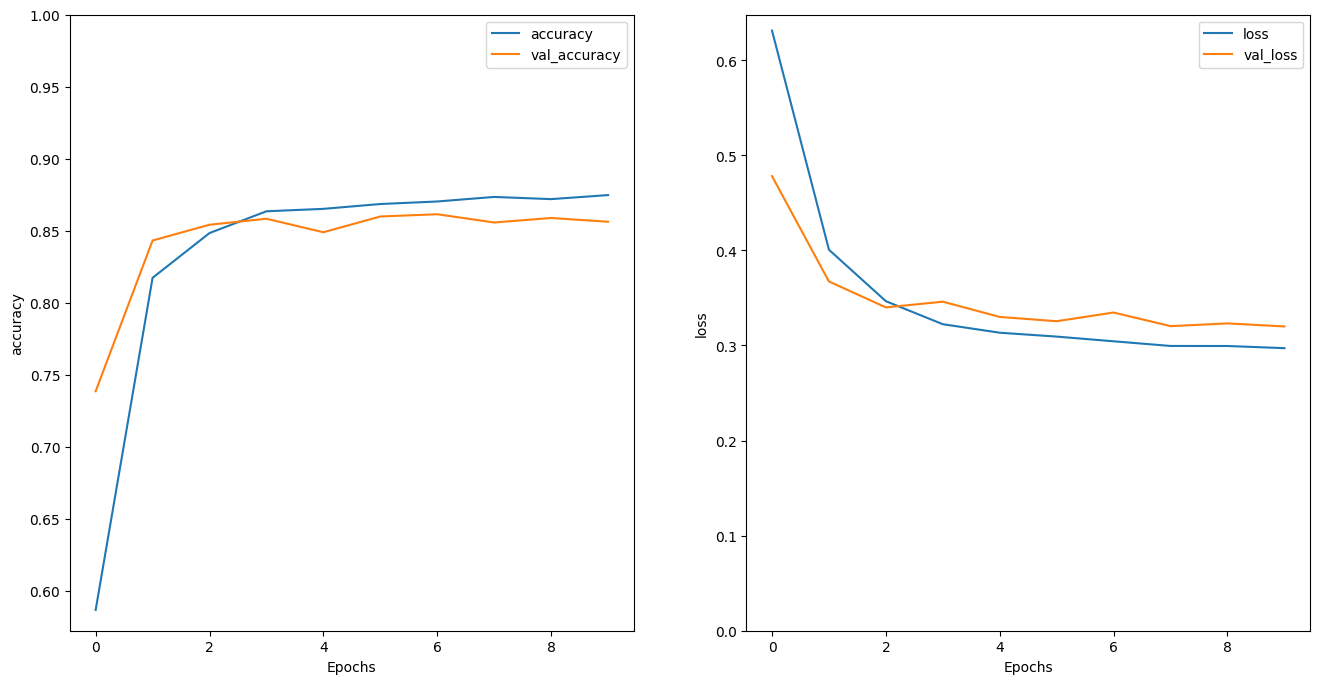

In [ ]:
plt.figure(figsize=(16, 8)) # plotting the training and validation accuracy and loss curves for a Keras model
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


### **Stack Two or More LSTM Layers**

In [ ]:
model = tf.keras.Sequential([ # defines a sequential neural network model for text classification using TensorFlow's Keras API
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 79s 158ms/step - loss: 0.6083 - accuracy: 0.6123 - val_loss: 0.4595 - val_accuracy: 0.7651
Epoch 2/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3879 - accuracy: 0.8312 - val_loss: 0.3530 - val_accuracy: 0.8490
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3380 - accuracy: 0.8585 - val_loss: 0.3468 - val_accuracy: 0.8354
Epoch 4/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3236 - accuracy: 0.8621 - val_loss: 0.3270 - val_accuracy: 0.8646
Epoch 5/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3130 - accuracy: 0.8662 - val_loss: 0.3256 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3053 - accuracy: 0.8694 - val_loss: 0.3207 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3009 - accuracy: 0.8714 - val_loss: 0.3183 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 51ms/step - loss: 0.3276 - accuracy: 0.8618
Test Loss: 0.327629417181015
Test Accuracy: 0.8617600202560425


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.950486]]


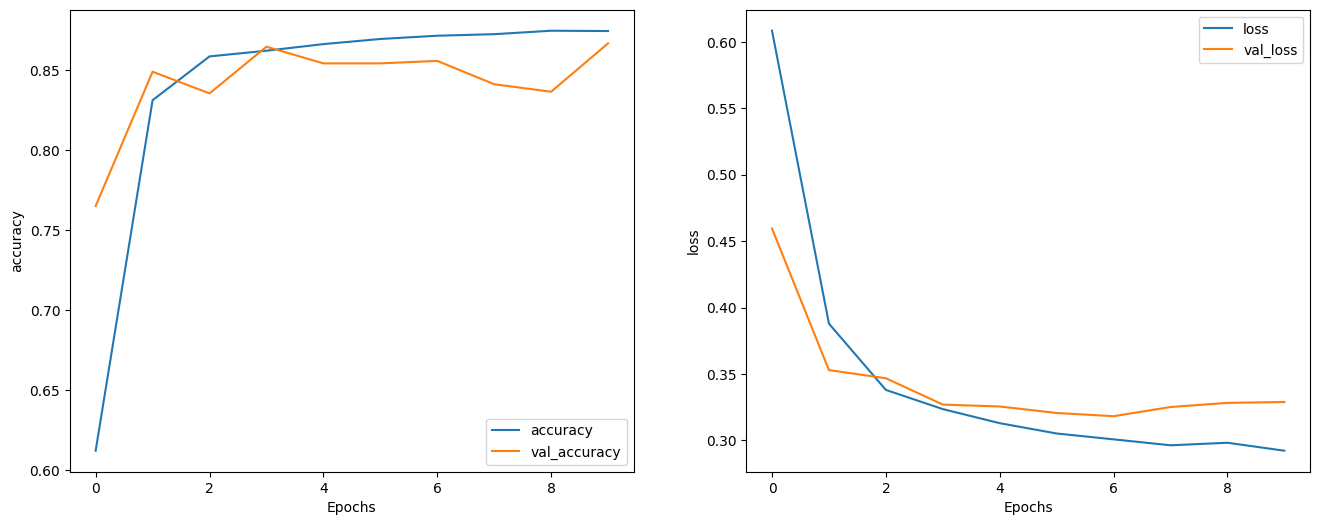

In [ ]:
plt.figure(figsize=(16, 6)) # plotting the training and validation accuracy and loss curves for a Keras model
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')